<a href="https://colab.research.google.com/github/rch16/RecycleHelper/blob/master/Machine%20Learning/Optimised%20Model/wasteclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install talos

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 8.7MB 10.3MB/s 
     |████████████████████████████████| 109.2MB 28kB/s 
     |████████████████████████████████| 378kB 54.0MB/s 
     |████████████████████████████████| 839kB 44.6MB/s 
     |████████████████████████████████| 26.6MB 115kB/s 
     |████████████████████████████████| 491kB 54.8MB/s 
     |████████████████████████████████| 3.2MB 42.4MB/s 
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=47133d0afd36bcb247f0b39725b7fb05319ef08ec4975d916bc66bda3b83e86c
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=6178f1bf82c3d66587b0d56f7070129159ea98da18b0a2085f0ffbb7f4236c2e
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for kerasplotlib: 

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras
import zipfile as zf
import numpy as np
import seaborn as sns
import pandas as pd

import sys
import cv2
import csv
import os
import re
import shutil
import random
import talos

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential 
from tensorflow.data import Dataset
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Helper Functions

The following helper functions were written by Collin Ching for his post "How to build an image classifier for waste sorting"

article : https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478

python notebook : https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

In [0]:
# splits indices for a folder into train, validation, and test indices with random sampling   
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# gets file names for a particular type of trash, given indices
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

# moves group of source files to another folder
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
def create_directory(): 
    # paths will be train/cardboard, train/glass, etc...
    subsets = ['train','valid']
    waste_types = ['cardboard','glass','metal','paper','plastic','trash']

    # create destination folders for data subset and waste type
    for subset in subsets:
        for waste_type in waste_types:
            folder = os.path.join(data_path,subset,waste_type)
            if not os.path.exists(folder):
                os.makedirs(folder)

    if not os.path.exists(os.path.join(data_path,'test')):
        os.makedirs(os.path.join(data_path,'test'))

    # move files to destination folders for each waste type
    for waste_type in waste_types:
        source_folder = os.path.join(path,waste_type)
        train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)

        # move source files to train
        train_names = get_names(waste_type,train_ind)
        train_source_files = [os.path.join(source_folder,name) for name in train_names]
        train_dest = train_path+"/"+waste_type
        move_files(train_source_files,train_dest)

        # move source files to valid
        valid_names = get_names(waste_type,valid_ind)
        valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
        valid_dest = valid_path+"/"+waste_type
        move_files(valid_source_files,valid_dest)

        # move source files to test
        test_names = get_names(waste_type,test_ind)
        test_source_files = [os.path.join(source_folder,name) for name in test_names]

        # I use data/test here because the images can be mixed up
        move_files(test_source_files,test_path)

In [0]:
def createFileList(myDir, format='.jpg'):
    fileList = []
    print(myDir)
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList

End of Collin's code

In [0]:
def stringContains(filePath):
    if "paper" in filePath:
        return 1
    elif "cardboard" in filePath:
        return 2
    elif "trash" in filePath:
        return 3
    elif "plastic" in filePath:
        return 4
    elif "metal" in filePath:
        return 5
    elif "glass" in filePath:
        return 6
    else:
        return 7

def convertToMatrix(fileList,num_images):
    
    num_pixels = 196608
    data = np.empty((num_images,num_pixels))
    labels = []
    label_count = [0,0,0,0,0,0,0]
    index = 0
    
    for file in fileList:
        
        img = Image.open(file) # open image
        arr = np.array(img.convert('L')) # convert to grey and place in numpy array
        vec = arr.ravel() # flatten to vector
        data[index,:] = vec.T # add to matrix
        
        name = stringContains(img.filename) # get image name
        labels = np.append(labels,name) # add to array
        label_count[name] += 1
        
        index += 1
        
    return data, labels, label_count

## Import Images

In [0]:
path = "/content/dataset-resized"
data_path = "/content/data"
test_path = "/content/data/test"
train_path = "/content/data/train"
valid_path = "/content/data/valid"

In [7]:
files = zf.ZipFile("/content/dataset-resized.zip",'r')
files.extractall()
files.close()

print(files)

<zipfile.ZipFile [closed]>


In [8]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'plastic', 'trash', 'paper', 'cardboard', 'metal', 'glass']

In [0]:
create_directory()

In [8]:
train_files = createFileList(train_path,format='.jpg')
test_files = createFileList(test_path,format='.jpg')
valid_files = createFileList(valid_path,format='.jpg')
fileList = createFileList(path,format='.jpg')

/content/data/train
/content/data/test
/content/data/valid
/content/dataset-resized


In [9]:
print(len(train_files), "training images")
print(len(test_files), "testing images")
print(len(valid_files), "validation images")

1262 training images
635 testing images
630 validation images


## Data Processing

Convert images to arrays

In [10]:
train,train_l,train_count = convertToMatrix(train_files,1262)
test,test_l,test_count = convertToMatrix(test_files,635)
valid,valid_l,valid_count = convertToMatrix(valid_files,630)

train = train.astype('float32')
train_l = train_l.astype('uint8')
test = test.astype('float32')
test_l = test_l.astype('uint8')
valid = valid.astype('float32')
valid_l = valid_l.astype('uint8')

print("data")
print(train.shape)
print(test.shape)
print(valid.shape)

print("")

print("labels")
print(train_l.shape)
print(test_l.shape)
print(valid_l.shape)

print("")
print("count")
print(train_count)
print(test_count)
print(valid_count)

data
(1262, 196608)
(635, 196608)
(630, 196608)

labels
(1262,)
(635,)
(630,)

count
[0, 297, 201, 68, 241, 205, 250]
[0, 149, 101, 35, 121, 103, 126]
[0, 148, 101, 34, 120, 102, 125]


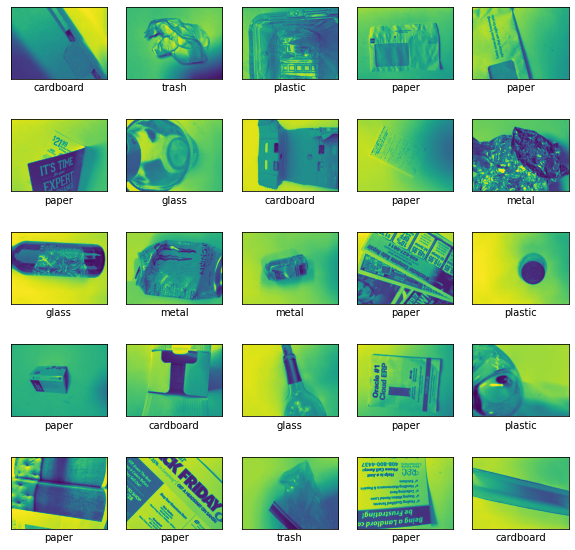

In [11]:
class_names = [' ', 'paper', 'cardboard', 'trash', 'plastic', 'metal','glass']

random_idx = []
for i in range(25):
    random.seed(i)
    random_idx.append(random.randrange(0,1262))
    
plt.figure(figsize=(10,10))
for i in range(25):
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    idx = random_idx[i]
    image = train[idx].reshape((384,512))
    plt.imshow(image)
    plt.xlabel(class_names[train_l[idx]])
    
plt.show()

Convert labels to one hot encoding

In [18]:
train_labels = to_categorical(train_l).astype('uint8')
test_labels = to_categorical(test_l).astype('uint8')
valid_labels = to_categorical(valid_l).astype('uint8')


print("Labels:")
print("train", train_l.shape)
print("test", test_l.shape)
print("validate", valid_l.shape)

print("")

print("One Hot Encoded Labels:")
print("train", train_labels.shape)
print("test", test_labels.shape)
print("validate", valid_labels.shape)

print("")

print(train_l[0])
print(train_labels[0])

Labels:
train (1262,)
test (635,)
validate (630,)

One Hot Encoded Labels:
train (1262, 7)
test (635, 7)
validate (630, 7)

4
[0 0 0 0 1 0 0]


Reshape data

In [0]:
rows = 384
cols = 512

## channel last configuration
train_data = train.reshape(train.shape[0],rows,cols,1)
test_data = test.reshape(test.shape[0],rows,cols,1)
valid_data = valid.reshape(valid.shape[0],rows,cols,1)

Normalise data

In [13]:
train_data /= 255.0
test_data /= 255.0
valid_data /= 255.0

print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(1262, 384, 512, 1)
(635, 384, 512, 1)
(630, 384, 512, 1)


## CNN Architecture

In [0]:
# input data
n_classes = 7
rows = 384
cols = 512
input_shape = (rows,cols,1)
class_weights = {0: 0,
                 1: 7,
                 2: 10,
                 3: 30,
                 4: 8,
                 5: 10,
                 6: 8}

# hyperparameters
batch_size = 75
epochs = 200
dropout_prob = 0.5
lr = 0.01
m = 0.2

# model architecture
opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
pool_size = 2
num_filters1 = 32
num_filters2 = 64
num_filters3 = 128
filter_size = 5
filter_size = 5

In [0]:
p = {'lr': (0.001,0.01,0.1),
     'batch_size': (50,75,100),
     'epochs': (50,100,200),
     'dropout': (0,0.2,1),
     'mom': (0.0,0.2,0.4)
}

In [0]:
def waste_classifier_model(x_train,y_train,x_val,y_val,params): 
    model = Sequential() #name="Waste Classifier Model 2")

    model.add(InputLayer(input_shape=input_shape))

    model.add(Dropout(params['dropout']))

    model.add(Conv2D(num_filters1,filter_size,activation='relu',data_format="channels_last"))#,input_shape=input_shape,))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(num_filters2,filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    # the output softmax layer will have one node for each class
    model.add(Flatten())
    model.add(Dense(n_classes,activation='softmax'))
    
    opt = tensorflow.keras.optimizers.SGD(learning_rate=params['lr'], momentum=params['mom'])
    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])

    model.summary()

    output = model.fit(x_train,y_train,batch_size=params['batch_size'],epochs=params['epochs'],class_weight=class_weights,validation_data=[x_val,y_val])

    return output, model

In [1]:
scan_object = talos.Scan(train_data,
                         train_labels,
                         params=p,
                         model=waste_classifier_model,
                         experiment_name='waste_classifier',
                         fraction_limit=.001)

NameError: ignored

In [19]:
K.clear_session()
waste_model = waste_classifier_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 380, 508, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 190, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 186, 250, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 93, 125, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 744000)            0         
_________________________________________________________________
dense (Dense)                (None, 7)                 5208007   
Tota

Convert to tensorflow dataset

In [1]:
train_dataset = Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = Dataset.from_tensor_slices((test_data, test_labels))
valid_dataset = Dataset.from_tensor_slices((valid_data, valid_labels))

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

print(train_dataset)


NameError: ignored

In [21]:
waste_model.fit(train_dataset,
                class_weight=class_weights,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2)

ValueError: ignored

In [0]:
test_loss, test_acc = waste_model.evaluate(test_dataset)

print("Test accuracy:", test_acc)

In [0]:
print(test_dataset)
predictions = waste_model.predict(test_dataset)

In [0]:
print(predictions.shape)

print(predictions[0])

In [0]:
class_labels = ['paper', 'cardboard', 'trash', 'plastic', 'metal', 'glass']
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

In [0]:
print(test_labels.shape)

In [0]:
print('Confusion Matrix')
print(matrix)
print('Classification Report')
print(classification_report(test_labels.argmax(axis=1), predictions.argmax(axis=1), target_names=class_labels))